### 1. Importing Module

In [27]:
# Import module yang dibutuhkan

import os, re, json
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
import catboost
import warnings; warnings.simplefilter('ignore')
import shap, graphviz
from imblearn.over_sampling import SMOTENC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool, cv
from catboost.eval.catboost_evaluation import *
from catboost import *
from catboost import datasets
from catboost.utils import create_cd
%matplotlib inline 
plt.style.use('bmh'); sns.set()

print('Imported Module')

Imported Module


### 2. Loading Dataset

Dataset yang digunakan dalam penelitian ini adalah dataset yang telah tersedia di https://github.com/fcakyon/instafake-dataset. Dataset tersebut terdiri atas dua buah set yang masing-masing berupa file json, yaitu fake account dan automated account.

Dataset fake account dikumpulkan dari akun instagram dari berbagai negara yang kemudian dilabeli secara manual sehingga terkumpul sebanyak 994 akun real dan 200 akun palsu. Informasi yang tersedia dalam dataset tersebut adalah jumlah follower, jumlah following, jumlah posting-an, akun memiliki foto profil atau tidak, bersifat private atau tidak, jumlah karakter pada biografi akun, jumlah karakter pada username, dan jumlah digit pada username. Dataset ini nantinya akan digunakan dalam mendeteksi fake follower.

In [28]:
# Membuat dataframe FakeReal Account

# Buka file json 
with open("FakeReal.json", "r") as file:
    data = json.load(file)
        
dataframe = pd.DataFrame()

for i in data:
    user_follower_count = i["userFollowerCount"]
    user_following_count = i["userFollowingCount"]
    follower_following_ratio = user_follower_count/max(1,user_following_count)
            
    temp_dataframe = pd.Series({"user_media_count":i["userMediaCount"],
                                "user_follower_count":i["userFollowerCount"],
                                "user_following_count":i["userFollowingCount"],
                                "user_has_profil_pic":i["userHasProfilPic"],
                                "user_is_private":i["userIsPrivate"],
                                "follower_following_ratio":follower_following_ratio,
                                "user_biography_length":i["userBiographyLength"],
                                "username_length":i["usernameLength"],
                                "username_digit_count":i["usernameDigitCount"],
                                "is_fake":i["isFake"]
                                })
    
    dataframe = dataframe.append(temp_dataframe, ignore_index=True)

dataframe[['user_has_profil_pic', 'user_is_private', 'is_fake']] = dataframe[['user_has_profil_pic','user_is_private','is_fake']].astype('int32')
dataframe=dataframe[['is_fake','follower_following_ratio','user_biography_length','user_follower_count','user_following_count','user_has_profil_pic','user_is_private','user_media_count','username_digit_count','username_length']]

cols = list(dataframe.columns.values)
print("jumlah data :", len(dataframe))

jumlah data : 1194


In [129]:
# Menampilkan lima data pertama
dataframe.head()

is_fake  follower_following_ratio  user_biography_length  \
0        1                  0.012907                    0.0   
1        1                  0.078603                    0.0   
2        1                  0.037594                    0.0   
3        1                  0.130841                    0.0   
4        1                  0.056762                    0.0   

   user_follower_count  user_following_count  user_has_profil_pic  \
0                 25.0                1937.0                    1   
1                324.0                4122.0                    1   
2                 15.0                 399.0                    0   
3                 14.0                 107.0                    1   
4                264.0                4651.0                    1   

   user_is_private  user_media_count  username_digit_count  username_length  
0                1               0.0                   0.0             10.0  
1                0               0.0                   4.0             15.0  
2                0               0.0                   3.0             12.0  
3                0               1.0                   1.0             10.0  
4                0               0.0                   0.0             14.0

In [130]:
# Melihat Ukuran Data
N, P = dataframe.shape
print('baris = ', N, ', Kolom = ', P)

dataframe.info()

baris =  1194 , Kolom =  10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   is_fake                   1194 non-null   int32  
 1   follower_following_ratio  1194 non-null   float64
 2   user_biography_length     1194 non-null   float64
 3   user_follower_count       1194 non-null   float64
 4   user_following_count      1194 non-null   float64
 5   user_has_profil_pic       1194 non-null   int32  
 6   user_is_private           1194 non-null   int32  
 7   user_media_count          1194 non-null   float64
 8   username_digit_count      1194 non-null   float64
 9   username_length           1194 non-null   float64
dtypes: float64(7), int32(3)
memory usage: 79.4 KB


In [131]:
# Mencetak Nama Kolom
print(dataframe.columns.values)  

['is_fake' 'follower_following_ratio' 'user_biography_length'
 'user_follower_count' 'user_following_count' 'user_has_profil_pic'
 'user_is_private' 'user_media_count' 'username_digit_count'
 'username_length']


Dari info diatas dapat diketahui bahwa dataset memuat 10 variabel, yaitu
1. follower_following_ratio : Perbandingan jumlah follower dengan jumlah following dari setiap akun
2. is_fake : Apakah akun merupakan akun palsu (Bernilai Benar = 1) atau akun asli (Bernilai salah = 0)
3. user_biography_length : Jumlah karakter dalam biografi akun
4. user_follower_count : Jumlah follower dalam setiap akun
5. user_following_count : Jumlah following dalam setiap akun
6. user_has_profil_pic : Apakah akun memiliki foto profil atau tidak
7. user_is_private : Apakah akun bersifat private atau tidak
8. user_media_count : Jumlah postingan yang terdapat dalam setiap akun
9. username_digit_count : Jumlah digit pada username
10. username_length : Jumlah karakter pada username

### 3. Feature Preparation

In [10]:
# Mengecek Missing Values
print(dataframe.isnull().sum())

is_fake                     0
follower_following_ratio    0
user_biography_length       0
user_follower_count         0
user_following_count        0
user_has_profil_pic         0
user_is_private             0
user_media_count            0
username_digit_count        0
username_length             0
dtype: int64


Dari output diatas terlihat bahwa tidak terdapat missing value pada setiap variabelnya.

In [29]:
# Deklarasi fitur kategorik

cat_features = ['user_has_profil_pic', 'user_is_private']
cat_features

['user_has_profil_pic', 'user_is_private']

In [30]:
# Membagi menjadi data train dan data test

train, test = train_test_split(dataframe, test_size = 0.2, random_state = 42) # 80% train dan 20% test

In [31]:
# Memisahkan fitur(x) dan label(y) 

x = train.drop('is_fake', axis = 1)
y = train.is_fake

x_test = test.drop('is_fake', axis = 1)
y_test = test.is_fake

In [32]:
# Jika akan melatih sebuah model, maka kita harus dapat mendeteksi overfitting dan memilih parameter terbaik. 
# Untuk melakukan hal itu kita perlu memiliki dataset validasi.

x_train, x_validation, y_train, y_validation = train_test_split(x, y, train_size=0.8, random_state=42)

# Pool Class digunakan sebagai dataset di CatBoost yang menyimpan semua informasi tentang dataset 
# (fitur, label, indeks fitur kategorik, bobot).
# Sama halnya seperti menggunakan numpy array atau dataframe.
# Akan tetapi menggunakan Pool Class adalah cara paling efisien dalam hal memori dan kecepatan.  

train_pool = Pool(data=x_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=x_test, label=y_test, cat_features=cat_features)
validation_pool = Pool(data=x_validation, label=y_validation, cat_features=cat_features)

print("{:<20}{}".format("Train size:", x_train.shape[0]))
print("{:<20}{}".format("Test size:", x_test.shape[0]))
print("{:<20}{}".format("Validation size:", x_validation.shape[0]))

Train size:         764
Test size:          239
Validation size:    191


### 4. Oversampling Data dengan SMOTE-NC

Fake Account 200
Real Account 994


Text(0.5, 1, 'Class Counts')

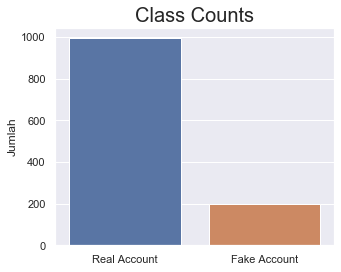

In [33]:
# Menampilkan jumlah masing-masing kelas

fake = dataframe[dataframe["is_fake"] == 1].shape[0]
real = dataframe[dataframe["is_fake"] == 0].shape[0]
print("Fake Account", fake)
print("Real Account", real) 
plt.figure(figsize=(5, 4))
sns.countplot(dataframe["is_fake"])
plt.xticks((0, 1), ["Real Account", "Fake Account"])
plt.xlabel("")
plt.ylabel("Jumlah")
plt.title("Class Counts", y=1, fontdict={"fontsize": 20})

Kedua kelas tidak seimbang. Dimana terdapat 994 akun nyata dan 200 akun palsu.

In [8]:
print('Total Data Train: {}'.format(x_train.shape[0]), 'dengan Jumlah Real Account {}'.format(sum(y_train==0)), 'dan Jumlah Fake Account {}'.format(sum(y_train==1)))
print('\nTotal Data Test: {}'.format(x_test.shape[0]), 'dengan Jumlah Real Account {}'.format(sum(y_test==0)), 'dan Jumlah Fake Account {}'.format(sum(y_test==1)))

Total Data Train: 764 dengan Jumlah Real Account 637 dan Jumlah Fake Account 127

Total Data Test: 239 dengan Jumlah Real Account 200 dan Jumlah Fake Account 39


In [34]:
# Oversampling SMOTE-NC

ovr = SMOTENC(random_state=42, categorical_features=[0,5,6])
x_over, y_over = ovr.fit_resample(x_train, y_train.ravel())

In [35]:
x_table_smotenc = pd.DataFrame(x_over)
y_table_smotenc = pd.DataFrame(y_over)
balanced = pd.concat([y_table_smotenc, x_table_smotenc], axis=1)
balanced = pd.DataFrame(balanced)

balanced.columns = [
    'is_fake',
    'follower_following_ratio',
    'user_biography_length',
    'user_follower_count',
    'user_following_count',
    'user_has_profil_pic',
    'user_is_private',
    'user_media_count',
    'username_digit_count',
    'username_length'
]

Fake Account 637
Real Account 637


Text(0.5, 1, 'Class Counts')

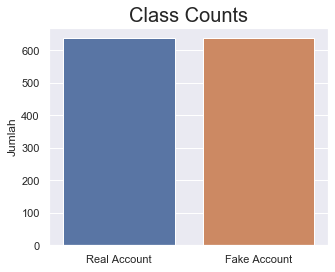

In [36]:
# Menampilkan jumlah masing-masing kelas

fake = balanced[balanced["is_fake"] == 1].shape[0]
real = balanced[balanced["is_fake"] == 0].shape[0]
print("Fake Account", fake)
print("Real Account", real)
plt.figure(figsize=(5, 4))
sns.countplot(balanced["is_fake"])
plt.xticks((0, 1), ["Real Account", "Fake Account"])
plt.xlabel("")
plt.ylabel("Jumlah")
plt.title("Class Counts", y=1, fontdict={"fontsize": 20})

In [12]:
print('Total Data Train: {}'.format(x_over.shape[0]), 'dengan Jumlah Real Account {}'.format(sum(y_over==0)), 'dan Jumlah Fake Account {}'.format(sum(y_over==1)))
print('Total Data Test: {}'.format(x_test.shape[0]), 'dengan Jumlah Real Account {}'.format(sum(y_test==0)), 'dan Jumlah Fake Account {}'.format(sum(y_test==1)))

Total Data Train: 1274 dengan Jumlah Real Account 637 dan Jumlah Fake Account 637
Total Data Test: 239 dengan Jumlah Real Account 200 dan Jumlah Fake Account 39


In [13]:
balanced.head()

is_fake  follower_following_ratio  user_biography_length  \
0        0                  1.003096                    0.0   
1        0                  0.545643                   30.0   
2        0                  0.899471                   27.0   
3        0                  0.787234                   53.0   
4        0                  0.894334                   34.0   

   user_follower_count  user_following_count  user_has_profil_pic  \
0                324.0                 323.0                    1   
1                263.0                 482.0                    1   
2                340.0                 378.0                    1   
3                740.0                 940.0                    1   
4                584.0                 653.0                    1   

   user_is_private  user_media_count  username_digit_count  username_length  
0                1             114.0                   0.0             10.0  
1                1              29.0                   0.0              8.0  
2                1               9.0                   0.0             12.0  
3                1             483.0                   0.0              9.0  
4                1              88.0                   0.0              9.0

In [14]:
balanced.shape

(1274, 10)

### 5. Data Visualization

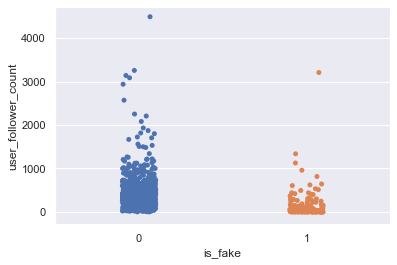

In [8]:
# Plot jumlah follower

p = sns.stripplot(x=dataframe['is_fake'], y=dataframe['user_follower_count'])

Dari scatterplot di atas terlihat bahwa sebagian besar akun fake memiliki jumlah follower yang sedikit, yaitu kurang dari 500 follower.  Sedangkan akun real memiliki jumlah follower yang lebih banyak, hingga ada yang berjumlah 3000 follower.

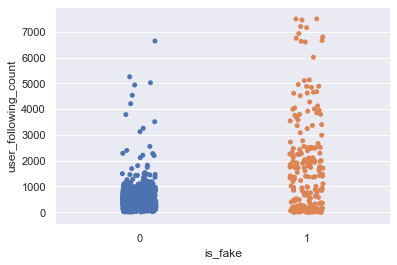

In [9]:
# Plot jumlah following

p = sns.stripplot(x=dataframe['is_fake'], y=dataframe['user_following_count'])

Dari scatterplot di atas terlihat bahwa akun fake memiliki following dengan jumlah yang besar yaitu berjumlah ribuan hingga mencapai 7000. Sebaliknya, sebagian besar akun asli memiliki following yang lebih sedikit yaitu kurang dari 1000.

In [6]:
# Melihat rata-rata akun yang merupakan fake atau real berdasarkan kepemilikan foto profil

dataframe[['user_has_profil_pic', 'is_fake']].groupby(['user_has_profil_pic'], as_index =False).mean().sort_values(by='is_fake', ascending = False)

user_has_profil_pic   is_fake
0                    0  0.858696
1                    1  0.109800

Rata-rata akun fake tanpa foto profil jauh lebih besar dibandingkan dengan akun fake yang memiliki foto profil, artinya berdasarkan data yang kita punya sebagian besar akun fake tidak memiliki foto profil.

In [9]:
# Melihat jumlah akun yang merupakan fake atau real berdasarkan akun tersebut disembunyikan (privat) atau tidak

dataframe[['user_is_private', 'is_fake']].groupby(['user_is_private'], as_index =False).sum().sort_values(by='is_fake', ascending = False)

user_is_private  is_fake
0                0      135
1                1       65

Jumlah akun fake yang tidak disembunyikan (privat) lebih banyak dibandingkan dengan akun fake yang disembunyikan, artinya berdasarkan data yang kita punya sebagian besar akun fake tidak disembunyikan.

### 6. Basic Statistics

In [10]:
# Statistika deskriptif dari semua variabel(termasuk data kategorik)

dataframe.describe(include='all')

is_fake  follower_following_ratio  user_biography_length  \
count  1194.000000               1194.000000            1194.000000   
mean      0.167504                  0.812195              22.847571   
std       0.373582                  0.804559              33.492868   
min       0.000000                  0.000000               0.000000   
25%       0.000000                  0.481885               0.000000   
50%       0.000000                  0.839351               7.000000   
75%       0.000000                  1.003664              33.000000   
max       1.000000                 16.800000             150.000000   

       user_follower_count  user_following_count  user_has_profil_pic  \
count          1194.000000           1194.000000          1194.000000   
mean            369.095477            744.261307             0.922948   
std             372.775741           1032.526420             0.266786   
min               0.000000              0.000000             0.000000   
25%             152.000000            267.000000             1.000000   
50%             304.000000            449.000000             1.000000   
75%             481.000000            711.000000             1.000000   
max            4492.000000           7497.000000             1.000000   

       user_is_private  user_media_count  username_digit_count  \
count      1194.000000       1194.000000           1194.000000   
mean          0.657454         57.596315              0.495812   
std           0.474760        107.402157              1.212010   
min           0.000000          0.000000              0.000000   
25%           0.000000          3.000000              0.000000   
50%           1.000000         20.000000              0.000000   
75%           1.000000         67.000000              0.000000   
max           1.000000       1058.000000             10.000000   

       username_length  
count      1194.000000  
mean         11.123953  
std           2.998135  
min           5.000000  
25%           9.000000  
50%          11.000000  
75%          13.000000  
max          30.000000

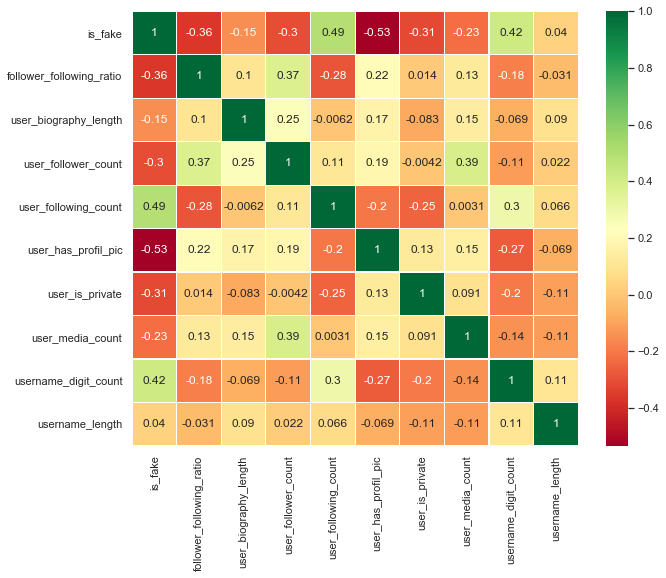

In [11]:
# Melihat heatmap untuk mengetahui korelasi antarvariabel

sns.heatmap(dataframe.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

### 7. Model Training

In [37]:
# Menyetel beberapa parameter

params = {
    # Secara default jumlah iterasi = 1000. Jika menurunkan jumlah iterasi maka learning rate ditingkatkan agar proses konvergen.
    'iterations': 500, 
    'learning_rate': 0.407227,
    #'learning_rate': 0.46181411601283945,  # Diperoleh dari hasil parameter tuning
    'custom_loss': ['Accuracy', 'AUC'],
    'loss_function': 'Logloss',
    'random_seed': 42,
    'l2_leaf_reg' : 4.0,               # Untuk meningkatkan kualitas model, diperoleh dari hasil parameter tuning
    'logging_level': 'Verbose',
    # Ansambel pohon yang dihasilkan menyusut ke iterasi terbaik.
    # Model dikecilkan menjadi beberapa pohon ketika mendapatkan nilai metrik evaluasi terbaik pada dataset validasi.
    'use_best_model': True,  
    # Menggunakan penghentian awal (early stopping) sebagai detektor overfitting. 
    # Dapat meningkatkan kualitas juga tetap dapat menghemat waktu.
    # Akan lebih baik jika menghentikan proses boosting lebih awal (sebelum overfitting dimulai).
    'early_stopping_rounds':40,
    'max_ctr_complexity': 1,          # Tanpa kombinasi fitur. Akan mempercepat pelatihan
    'boosting_type': 'Plain',         # Secara default menggunakan ordered untuk menghindari overfitting, tetapi komputasi besar
    # Menggunakan bootstrap_type eksponensial(default)
    'one_hot_max_size': 2,
    'leaf_estimation_method':'Newton'    
}

In [38]:
%%time
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validation_pool, plot=True, verbose=10)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2203400	test: 0.2298979	best: 0.2298979 (0)	total: 6.14ms	remaining: 3.06s
10:	learn: 0.0368711	test: 0.0582005	best: 0.0582005 (10)	total: 41.1ms	remaining: 1.83s
20:	learn: 0.0174706	test: 0.0529855	best: 0.0519489 (16)	total: 66.8ms	remaining: 1.52s
30:	learn: 0.0124641	test: 0.0490642	best: 0.0489680 (28)	total: 88.1ms	remaining: 1.33s
40:	learn: 0.0069372	test: 0.0537391	best: 0.0489680 (28)	total: 116ms	remaining: 1.3s
50:	learn: 0.0053429	test: 0.0525566	best: 0.0489680 (28)	total: 139ms	remaining: 1.22s
60:	learn: 0.0042260	test: 0.0565388	best: 0.0489680 (28)	total: 161ms	remaining: 1.16s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.04896799408
bestIteration = 28

Shrink model to first 29 iterations.
Wall time: 257 ms


Dengan ini kita dapat melihat bahwa nilai akurasi terbaik sebesar 0.9843 dicapai pada 10 langkah boosting.

In [80]:
# Melihat metric evaluasi

metric = model.eval_metrics(
    data=train_pool,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [81]:
print('AUC values:')
print(np.array(metric['AUC']))

AUC values:
[0.9813842  0.98755238 0.99299126 0.99449931 0.99671195 0.99775646
 0.99790479 0.99851049 0.99877625 0.99885042 0.99914708 0.99944375
 0.99951792 0.99951792 0.99978986 0.99983931 0.99993819 0.99993819
 0.99995056 0.99997528 0.99997528 0.99997528 0.99997528 0.99997528
 1.         1.         1.         1.         1.        ]


In [82]:
# Menggunakan data validasi

eval_metrics = model.eval_metrics(validation_pool, ['AUC'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [83]:
print(eval_metrics['AUC'][:6])

[0.9798613713001124, 0.9868864743349569, 0.9886661671037842, 0.9902585237916823, 0.9942862495316598, 0.9948482577744474]


In [84]:
print('Jumlah Pohon: {}'.format(model.tree_count_))
print('Akurasi Model: {:.4}'.format(
    accuracy_score(y_validation, model.predict(x_validation))  # Dilihat dari data validasi
))

Jumlah Pohon: 29
Akurasi Model: 0.9791


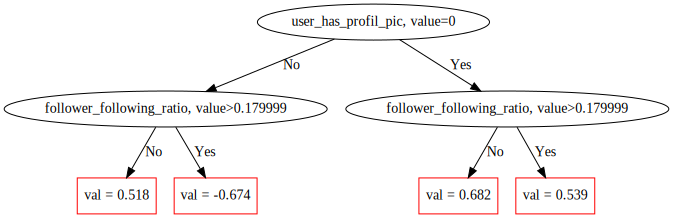

In [45]:
# Visualisasi Pohon

os.environ["PATH"] += os.pathsep + 'C:/Users/dell latitude/anaconda3/Library/bin/graphviz/'

model = CatBoostClassifier(
    max_depth=2, verbose=False, max_ctr_complexity=1, random_seed=42, iterations=2).fit(train_pool)

model.plot_tree(
    tree_idx=1,
    pool=train_pool     # "pool" adalah parameter wajib untuk pohon dengan minimal satu fitur kategorik
)

Pohon pertama hanya berisi satu split yang dibuat oleh fitur kategorik user_has_profil_pic. Split ini menempatkan objek yang tidak memiliki foto profil (No) ke kiri dan objek yang memilki foto profil (Yes) ke kanan.

CatBoost menggunakan pohon simetris atau pohon oblivious. Untuk setiap tingkat pohon CatBoost menggunakan fitur yang sama untuk membagi contoh pembelajaran ke partisi kiri dan kanan. Pada pohon tingkat pertama dipartisi dengan pemisahan pertama menjadi dua bagian, pada tingkat kedua setiap subpohon dibagi dengan pemisahan kedua dan seterusnya.

Dalam hal ini pohon dengan kedalaman 𝑘 memiliki tepat $2^𝑘$ daun dan $𝑘$ split, masing-masing terpisah pada lapisan berikutnya.

Ada tiga jenis pemisahan (split): "FloatFeature", "OneHotFeature", dan "OnlineCtr". Model tanpa fitur kategoris hanya berisi split "FloatFeature".

### 8. Feature Selection

In [19]:
# Melihat fitur mana yang paling penting untuk model

model.get_feature_importance(prettified=True)

Feature Id  Importances
0  follower_following_ratio    25.474994
1          user_media_count    17.351455
2      user_following_count    15.217888
3       user_follower_count    14.723578
4     user_biography_length     8.036401
5           username_length     7.714228
6       user_has_profil_pic     6.668809
7      username_digit_count     3.434355
8           user_is_private     1.378292

Terlihat bahwa fitur **`follower_following_ratio`** memiliki pengaruh terbesar terhadap hasil. 

In [20]:
# Melihat seluruh kumpulan data dan menganalisis pengaruh berbagai fitur pada objek dari kumpulan data tersebut. 
# Menghitung kepentingan untuk setiap objek. Setelah itu akan divisualisasikan

shap_info = model.get_feature_importance(train_pool, type = 'ShapValues')
shap_values = shap_info[:,:-1]
print(shap_values.shape)

(764, 9)


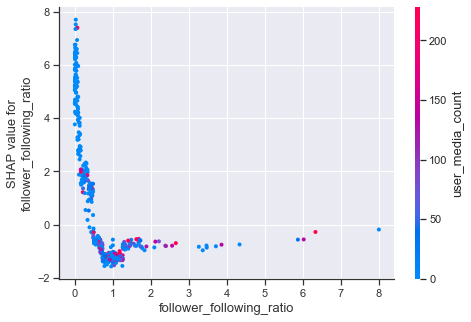

In [21]:
# Membuat plot ketergantungan SHAP untuk menunjukkan efek fitur tunggal di seluruh dataset
shap.dependence_plot("follower_following_ratio", shap_values, x_train)

Untuk memahami bagaimana satu fitur mempengaruhi keluaran model, kita dapat memplot nilai SHAP dari fitur tersebut vs. nilai fitur untuk semua contoh dalam dataset. Karena nilai SHAP mewakili fitur untuk perubahan dalam keluaran model, plot di atas mewakili perubahan prediksi suatu akun fake atau real berdasarkan follower_following_ratio (Perbandingan jumlah follower dengan jumlah following dari setiap akun). Dispersi vertikal pada nilai tunggal follower_following_ratio menunjukkan efek interaksi dengan fitur lain. Untuk lebih jelasnya, `dependence_plot` secara otomatis memilih fitur lain dengan menggunakan pewarnaan. Dalam hal ini pewarnaan oleh RAD, dimana menyoroti bahwa follower_following_ratio memiliki pengaruh yang lebih kecil terhadap prediksi suatu akun untuk daerah dengan nilai RAD yang tinggi.

Untuk mendapatkan gambaran umum tentang fitur mana yang paling penting untuk model, kita dapat memplot nilai SHAP dari setiap fitur untuk setiap sampel. Plot di bawah mengurutkan fitur berdasarkan jumlah besaran nilai SHAP di semua sampel, dan menggunakan nilai SHAP untuk menunjukkan distribusi dampak yang dimiliki setiap fitur pada keluaran model. Warna mewakili nilai fitur (merah tinggi, biru rendah).

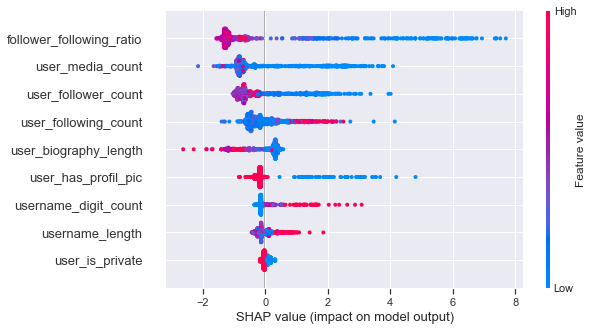

In [50]:
# Melihat informasi gabungan tentang pengaruh pada seluruh dataset.

shap.summary_plot(shap_values, x_train)

Dari grafik di atas kita dapat melihat bahwa nilai fitur follower_following_ratio memiliki pengaruh positif yang besar dan juga memiliki dampak positif terbesar untuk banyak objek.

In [22]:
# Menghapus beberapa fitur yang hanya memiliki sedikit pengaruh terhadap model
# Berdasarkan tabel feature importances dan grafik SHAP values dilihat tiga fitur terbawah.
# Sehingga fitur yang akan dihapus yaitu username_digit_count dan user_is_private yang sama-sama berada di urutan tiga terbawah.

data_feature_selection = dataframe.drop(['username_digit_count','user_is_private'], axis=1)

In [104]:
data_feature_selection.head()

is_fake  follower_following_ratio  user_biography_length  \
0        1                  0.012907                    0.0   
1        1                  0.078603                    0.0   
2        1                  0.037594                    0.0   
3        1                  0.130841                    0.0   
4        1                  0.056762                    0.0   

   user_follower_count  user_following_count  user_has_profil_pic  \
0                 25.0                1937.0                    1   
1                324.0                4122.0                    1   
2                 15.0                 399.0                    0   
3                 14.0                 107.0                    1   
4                264.0                4651.0                    1   

   user_media_count  username_length  
0               0.0             10.0  
1               0.0             15.0  
2               0.0             12.0  
3               1.0             10.0  
4               0.0             14.0

In [105]:
# Mencetak Nama Kolom
print(data_feature_selection.columns.values)  

['is_fake' 'follower_following_ratio' 'user_biography_length'
 'user_follower_count' 'user_following_count' 'user_has_profil_pic'
 'user_media_count' 'username_length']


### 9. Pemilihan Model Terbaik

#### 1) Tanpa SMOTE-NC

In [39]:
%%time

smote_params = params.copy()
smote_params.update({
    'train_dir': 'Model_Tanpa_SMOTENC'
})

model_tanpa_smote = CatBoostClassifier(**params)
model_tanpa_smote.fit(train_pool, eval_set=validation_pool, plot=True, verbose=10)

0:	learn: 0.2203400	test: 0.2298979	best: 0.2298979 (0)	total: 3.15ms	remaining: 1.57s
10:	learn: 0.0368711	test: 0.0582005	best: 0.0582005 (10)	total: 25.8ms	remaining: 1.15s
20:	learn: 0.0174706	test: 0.0529855	best: 0.0519489 (16)	total: 48.5ms	remaining: 1.11s
30:	learn: 0.0124641	test: 0.0490642	best: 0.0489680 (28)	total: 68ms	remaining: 1.03s
40:	learn: 0.0069372	test: 0.0537391	best: 0.0489680 (28)	total: 90.3ms	remaining: 1.01s
50:	learn: 0.0053429	test: 0.0525566	best: 0.0489680 (28)	total: 115ms	remaining: 1.01s
60:	learn: 0.0042260	test: 0.0565388	best: 0.0489680 (28)	total: 135ms	remaining: 973ms
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.04896799408
bestIteration = 28

Shrink model to first 29 iterations.
Wall time: 204 ms


=== Confusion Matrix ===
[[196   4]
 [  6  33]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       200
           1       0.89      0.85      0.87        39

    accuracy                           0.96       239
   macro avg       0.93      0.91      0.92       239
weighted avg       0.96      0.96      0.96       239



Accuracy: 0.9581589958158996
F1_score: 0.868421052631579
Recall_score: 0.8461538461538461
AUC_score: 0.913076923076923
Sensitivity 0.8461538461538461
Specificity 0.98
Precision 0.8918918918918919


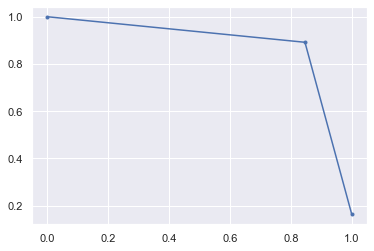

In [14]:
# Prediksi pada data test
model_predict=model_tanpa_smote.predict(x_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, model_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, model_predict))
print('\n')

# Akurasi Model

print("Accuracy:",metrics.accuracy_score(y_test, model_predict))
print("F1_score:",metrics.f1_score(y_test, model_predict))
print("Recall_score:",metrics.recall_score(y_test, model_predict))
print("AUC_score:",metrics.roc_auc_score(y_test, model_predict))
precision, recall, thresholds = metrics.precision_recall_curve(y_test, model_predict)

plt.plot(recall, precision, marker='.')

confusion = confusion_matrix(y_test, model_predict)

# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
print("Sensitivity",TP / float(TP + FN))
print("Specificity",TN / float(TN + FP))
print("Precision",TP / float(TP + FP))

#### 2) Dengan SMOTE-NC 

In [40]:
train_over_pool = Pool(data=x_over, label=y_over, cat_features=cat_features)

print("{:<20}{}".format("Train size:", x_over.shape[0]))
print("{:<20}{}".format("Test size:", x_test.shape[0]))
print("{:<20}{}".format("Validation size:", x_validation.shape[0]))

Train size:         1274
Test size:          239
Validation size:    191


In [41]:
%%time

smote_params = params.copy()
smote_params.update({
    'train_dir': 'Model_Dengan_SMOTENC'
})

model_smote = CatBoostClassifier(**params)
model_smote.fit(train_over_pool, eval_set=validation_pool, plot=True, verbose=10)

0:	learn: 0.2366468	test: 0.2329256	best: 0.2329256 (0)	total: 3.9ms	remaining: 1.95s
10:	learn: 0.0291179	test: 0.0768280	best: 0.0747200 (8)	total: 34.2ms	remaining: 1.52s
20:	learn: 0.0163024	test: 0.0720579	best: 0.0696675 (13)	total: 64.6ms	remaining: 1.47s
30:	learn: 0.0093103	test: 0.0750627	best: 0.0696675 (13)	total: 94.1ms	remaining: 1.42s
40:	learn: 0.0076050	test: 0.0779337	best: 0.0696675 (13)	total: 126ms	remaining: 1.41s
50:	learn: 0.0058639	test: 0.0807893	best: 0.0696675 (13)	total: 155ms	remaining: 1.37s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.06966748645
bestIteration = 13

Shrink model to first 14 iterations.
Wall time: 219 ms


=== Confusion Matrix ===
[[195   5]
 [  3  36]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       200
           1       0.88      0.92      0.90        39

    accuracy                           0.97       239
   macro avg       0.93      0.95      0.94       239
weighted avg       0.97      0.97      0.97       239



Accuracy: 0.9665271966527197
F1_score: 0.9
Recall_score: 0.9230769230769231
AUC_score: 0.9490384615384615
Sensitivity 0.9230769230769231
Specificity 0.975
Precision 0.8780487804878049


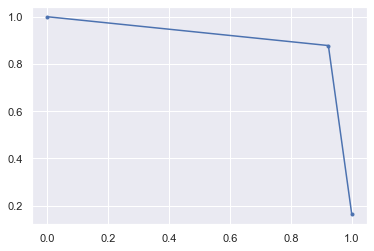

In [17]:
# Prediksi pada data test
model_predict=model_smote.predict(x_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, model_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, model_predict))
print('\n')

# Akurasi Model

print("Accuracy:",metrics.accuracy_score(y_test, model_predict))
print("F1_score:",metrics.f1_score(y_test, model_predict))
print("Recall_score:",metrics.recall_score(y_test, model_predict))
print("AUC_score:",metrics.roc_auc_score(y_test, model_predict))
precision, recall, thresholds = metrics.precision_recall_curve(y_test, model_predict)

plt.plot(recall, precision, marker='.')

confusion = confusion_matrix(y_test, model_predict)

# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
print("Sensitivity",TP / float(TP + FN))
print("Specificity",TN / float(TN + FP))
print("Precision",TP / float(TP + FP))

Dengan oversampling SMOTE-NC memberikan peningkatan pada nilai akurasi dari 0.96 menjadi 0.97. Begitu pula dengan skor F1, Recall dan juga AUC mengalami peningkatan.

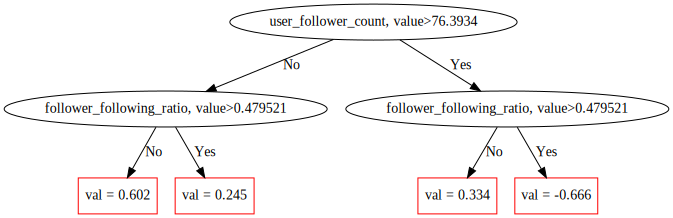

In [99]:
# Visualisasi Pohon

os.environ["PATH"] += os.pathsep + 'C:/Users/dell latitude/anaconda3/Library/bin/graphviz/'

model_pohon = CatBoostClassifier(
    max_depth=2, verbose=False, max_ctr_complexity=1, random_seed=42, iterations=2).fit(train_over_pool)

model_pohon.plot_tree(
    tree_idx=1,
    pool=train_pool     # "pool" adalah parameter wajib untuk pohon dengan minimal satu fitur kategorik
)

#### 3) Dengan Feature Selection

In [120]:
# Mencetak Nama Fitur-fitur yang Digunakan
print(data_feature_selection.columns.values)  

['is_fake' 'follower_following_ratio' 'user_biography_length'
 'user_follower_count' 'user_following_count' 'user_has_profil_pic'
 'user_media_count' 'username_length']


In [42]:
# Deklarasi fitur kategorik

cat_features_sel = ['user_has_profil_pic']
cat_features_sel

['user_has_profil_pic']

In [43]:
# Membuat pool class baru setelah feature selection

x_train_sel = x_over.drop(['username_digit_count','user_is_private'], axis=1) # Menggunakan data train oversampling
y_train_sel = y_over

x_test_sel = x_test.drop(['username_digit_count','user_is_private'], axis=1)
y_test_sel = y_test

x_validation_sel = x_validation.drop(['username_digit_count','user_is_private'], axis=1)
y_validation_sel = y_validation

train_sel_pool = Pool(data=x_train_sel, label=y_train_sel, cat_features=cat_features_sel)
test_sel_pool = Pool(data=x_test_sel, label=y_test_sel, cat_features=cat_features_sel)
validation_sel_pool = Pool(data=x_validation_sel, label=y_validation_sel, cat_features=cat_features_sel)

print("{:<20}{}".format("Train size:", x_train_sel.shape))
print("{:<20}{}".format("Test size:", x_test_sel.shape))
print("{:<20}{}".format("Validation size:", x_validation_sel.shape))

Train size:         (1274, 7)
Test size:          (239, 7)
Validation size:    (191, 7)


In [44]:
%%time

featureselection_params = params.copy()
featureselection_params.update({
    'train_dir': 'Model_Dengan_Feature_Selection'
})

model_seleksi_fitur = CatBoostClassifier(**params)
model_seleksi_fitur.fit(train_sel_pool, eval_set=validation_sel_pool, plot=True, verbose=10)

0:	learn: 0.1933083	test: 0.1915618	best: 0.1915618 (0)	total: 4.01ms	remaining: 2s
10:	learn: 0.0261737	test: 0.0825898	best: 0.0803846 (8)	total: 34.1ms	remaining: 1.51s
20:	learn: 0.0168289	test: 0.0883767	best: 0.0803846 (8)	total: 67.7ms	remaining: 1.54s
30:	learn: 0.0134202	test: 0.0860255	best: 0.0803846 (8)	total: 97.6ms	remaining: 1.48s
40:	learn: 0.0097854	test: 0.0882118	best: 0.0803846 (8)	total: 125ms	remaining: 1.4s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.08038460853
bestIteration = 8

Shrink model to first 9 iterations.
Wall time: 209 ms


=== Confusion Matrix ===
[[195   5]
 [  5  34]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.87      0.87      0.87        39

    accuracy                           0.96       239
   macro avg       0.92      0.92      0.92       239
weighted avg       0.96      0.96      0.96       239



Accuracy: 0.9581589958158996
F1_score: 0.8717948717948718
Recall_score: 0.8717948717948718
AUC_score: 0.9233974358974358
Sensitivity 0.8717948717948718
Specificity 0.975
Precision 0.8717948717948718


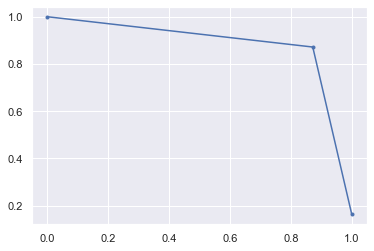

In [33]:
# Prediksi pada data test
model_predict=model_seleksi_fitur.predict(x_test_sel)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_sel, model_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_sel, model_predict))
print('\n')

# Akurasi Model

print("Accuracy:",metrics.accuracy_score(y_test_sel, model_predict))
print("F1_score:",metrics.f1_score(y_test_sel, model_predict))
print("Recall_score:",metrics.recall_score(y_test_sel, model_predict))
print("AUC_score:",metrics.roc_auc_score(y_test_sel, model_predict))
precision, recall, thresholds = metrics.precision_recall_curve(y_test_sel, model_predict)

plt.plot(recall, precision, marker='.')

confusion = confusion_matrix(y_test_sel, model_predict)

# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
print("Sensitivity",TP / float(TP + FN))
print("Specificity",TN / float(TN + FP))
print("Precision",TP / float(TP + FP))

Setelah dilakukan feature selection ternyata tidak memberikan hasil yang lebih baik. Hasil terbaik diperoleh dengan model oversampling tanpa feature selection.

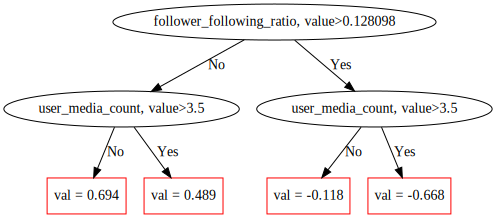

In [151]:
# Visualisasi Pohon

os.environ["PATH"] += os.pathsep + 'C:/Users/dell latitude/anaconda3/Library/bin/graphviz/'

model_pohon = CatBoostClassifier(
    max_depth=2, verbose=False, max_ctr_complexity=1, random_seed=42, iterations=2).fit(train_sel_pool)

model_pohon.plot_tree(
    tree_idx=1,
    pool=train_pool     # "pool" adalah parameter wajib untuk pohon dengan minimal satu fitur kategorik
)

#### Melihat Perbandingan Semua Model Secara Bersamaan

In [ ]:
MetricVisualizer(['Model_Tanpa_SMOTENC', 'Model_Dengan_SMOTENC', 'Model_Dengan_Feature_Selection']).start() 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### 10) Cross Validation

In [45]:
# Dengan menggunakan parameter dari model terbaik (smote)

cv_params_smote = model_smote.get_params()
cv_data_smote = cv(
    train_over_pool,
    cv_params_smote,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2300836	test: 0.2387821	best: 0.2387821 (0)	total: 89.5ms	remaining: 44.7s
1:	learn: 0.1118904	test: 0.1256779	best: 0.1256779 (1)	total: 161ms	remaining: 40s
2:	learn: 0.0704285	test: 0.0874497	best: 0.0874497 (2)	total: 236ms	remaining: 39.2s
3:	learn: 0.0552717	test: 0.0753661	best: 0.0753661 (3)	total: 310ms	remaining: 38.5s
4:	learn: 0.0464073	test: 0.0732111	best: 0.0732111 (4)	total: 400ms	remaining: 39.6s
5:	learn: 0.0392393	test: 0.0703860	best: 0.0703860 (5)	total: 480ms	remaining: 39.5s
6:	learn: 0.0366101	test: 0.0701135	best: 0.0701135 (6)	total: 580ms	remaining: 40.8s
7:	learn: 0.0319319	test: 0.0665832	best: 0.0665832 (7)	total: 667ms	remaining: 41s
8:	learn: 0.0309656	test: 0.0668545	best: 0.0665832 (7)	total: 764ms	remaining: 41.7s
9:	learn: 0.0287502	test: 0.0656649	best: 0.0656649 (9)	total: 849ms	remaining: 41.6s
10:	learn: 0.0268204	test: 0.0653160	best: 0.0653160 (10)	total: 935ms	remaining: 41.6s
11:	learn: 0.0236494	test: 0.0652415	best: 0.0652415 (1

In [46]:
cv_data_smote.head()

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0           0.238782          0.008675            0.230084   
1           1           0.125678          0.016198            0.111890   
2           2           0.087450          0.015104            0.070429   
3           3           0.075366          0.014716            0.055272   
4           4           0.073211          0.011773            0.046407   

   train-Logloss-std  test-Accuracy-mean  test-Accuracy-std  \
0           0.008428            0.972517           0.010922   
1           0.010332            0.975666           0.005943   
2           0.008778            0.975666           0.005943   
3           0.008856            0.976452           0.004717   
4           0.010624            0.979593           0.001334   

   train-Accuracy-mean  train-Accuracy-std  test-AUC-mean  test-AUC-std  
0             0.977235            0.002472       0.985591      0.005542  
1             0.977629            0.002054       0.994053      0.003987  
2             0.982729            0.002475       0.995441      0.003879  
3             0.987049            0.002353       0.996077      0.003893  
4             0.987050            0.002030       0.996059      0.003577

In [47]:
# Melihat nilai fungsi kerugian di setiap langkah boosting yang dirata-rata sebanyak 3 kali folds, 
# yang seharusnya dapat memberi perkiraan yang lebih akurat tentang kinerja model

print('Best validation accuracy score: {:.2f}±{:.2f} pada step {}'.format(
    np.max(cv_data_smote['test-Accuracy-mean']),
    cv_data_smote['test-Accuracy-std'][np.argmax(cv_data_smote['test-Accuracy-mean'])],
    np.argmax(cv_data_smote['test-Accuracy-mean'])
))

print('\nPrecise validation accuracy score: {}'.format(np.max(cv_data_smote['test-Accuracy-mean'])))

Best validation accuracy score: 0.98±0.00 pada step 12

Precise validation accuracy score: 0.9811652936486847


In [48]:
# Melihat nilai rata-rata dan standar deviasi Logloss untuk cross validation pada iterasi terbaik.

best_value = np.min(cv_data_smote['test-Logloss-mean'])  
best_iter = np.argmin(cv_data_smote['test-Logloss-mean'])

print('Best validation Logloss score: {:.4f}±{:.4f} pada step {}'.format(
    best_value,
    cv_data_smote['test-Logloss-std'][best_iter],
    best_iter)
)

print('\nPrecise validation Logloss score: {}'.format(np.min(cv_data_smote['test-Logloss-mean'])))

Best validation Logloss score: 0.0652±0.0168 pada step 11

Precise validation Logloss score: 0.06524153708256676


### 11) Menyimpan Model File JSON 

CatBoost juga mendukung ekspor model ke format JSON dan memuat model darinya.

In [50]:
# Save model JSON ke file

model_smote.save_model(
    'CatBoost_Model.json', 
    format='json',
    pool = train_over_pool  # parameter ini diperlukan hanya untuk model dengan fitur kategoris.
)

In [51]:
# Memuat model dari file sebagai JSON dan menunjukkan keys. Model json berisi model_info, oblivious_trees dan features_info. 

model_json = json.load(open('CatBoost_Model.json', 'r'))
model_json.keys()

dict_keys(['features_info', 'model_info', 'oblivious_trees', 'scale_and_bias'])

In [52]:
# Melihat nilai features_info
# Ini bisa berisi 𝑓𝑙𝑜𝑎𝑡_𝑓𝑒𝑎𝑡𝑢𝑟𝑒𝑠, 𝑐𝑎𝑡𝑒𝑔𝑜𝑟𝑖𝑐𝑎𝑙_𝑓𝑒𝑎𝑡𝑢𝑟𝑒𝑠 dan 𝑐𝑡𝑟𝑠, yang merupakan daftar deskripsi dari beberapa fitur.

model_json['features_info'].keys()

dict_keys(['cat_features_hash', 'categorical_features', 'float_features'])

Melihat bagaimana model JSON mendeskripsikan satu pohon. Pohon dengan kedalaman $𝑘$ dideskripsikan dengan $2^𝑘$ leaf_values, $2^k$ leaf_ weights dan $𝑘$ splits

In [53]:
def dump_json(item):
    print(json.dumps(item, indent=2))

dump_json(model_json['oblivious_trees'][0])  # Pohon pertama dari model

{
  "leaf_values": [
    0.9864534659291152,
    -1.5833090902616984,
    2.435880945490144,
    0.9932328900704678,
    1.3350205057106033,
    -0.22552835813885166,
    1.6884551576975706,
    0.7418150787493735,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0.4857819787737353,
    -1.1873527267051498,
    1.0015740850622497,
    1.1738169653655037,
    1.126910443290672,
    -0.7418150787493734,
    1.2157280010724303,
    0,
    0.8216344496694776,
    -0.8646097742748303,
    1.126910443290672,
    0,
    1.0123771395609582,
    -0.3746436216748444,
    0.8524761479110128,
    0,
    0,
    -0.9401108489663791,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "leaf_weights": [
    135,
    548,
    259,
    50,
    33,
    3,
    79,
    3,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    13,

- Daftar "leaf_values" menjelaskan nilai dalam daun. Ini adalah pohon dengan 4 daun, memiliki kedalaman 2, yang berarti memiliki dua split yang berbeda. Split pertama digunakan untuk membagi semua objek menjadi kiri dan kanan. Dan split kedua digunakan dua kali, untuk membagi objek kiri menjadi dua bagian, dan untuk membagi objek kanan menjadi dua bagian. Indeks dalam daftar dapat direpresentasikan menggunakan sistem angka basis-2 dengan cara berikut: 00, 01, 10, 11. Daun 00 adalah daun di mana split ke-0 dan split ke-1 sama dengan False. Daun 01 berisi objek di mana split ke-0 sama dengan False dan split ke-1 sama dengan True. Dan seterusnya.

- Bagian selanjutnya dari deskripsi pohon disebut "leaf_weights". Daftar ini mewakili jumlah bobot sampel pelatihan, yang ada di daun ini. Indeksasi daun dalam daftar ini sama dengan di "leaf_values".

- Bagian terakhir adalah "split", dan itu adalah deskripsi dari dua split yang digunakan pada pohon kedalaman dua. Setiap deskripsi berisi beberapa keys-values. Pertama, ini berisi parameter CatBoost internal $split\_index$. Ini adalah satu-satunya parameter yang digunakan oleh catboost saat memuat model, semua bagian lain dalam "splits" diabaikan (mereka digandakan di tempat yang berbeda), dan yang ada di sini hanya untuk membuat model lebih mudah dipahami.